In [1]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from MVAE import *
import cv2 

In [2]:
device = torch.device(1 if torch.cuda.is_available() else 0)
device

device(type='cuda', index=1)

In [3]:
TRAIN_MASK_DIR = './train/'

# Alternate Custom DataSet

In [4]:
import skimage.measure as skm
import pandas as pd
from PIL import Image
import os
import cv2 

In [5]:
dataSetDIR = f"D:\_0Luciano\_0PHD\datasets"
masksDir =  f'D:\_0Luciano\_0PHD\datasets\masks10-90'

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0] + '.png'
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [105]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

In [109]:
transformOut = transforms.Compose([transforms.GaussianBlur((7, 7), sigma=(0.1, 2.0)),
                                   ThresholdTransform(thr_255=127)
                                  ])

In [115]:
transform = transforms.Compose([transforms.Resize((64 , 64)),
                                transforms.Grayscale(num_output_channels=1)
                                ,transforms.ToTensor()])
masksDS = CustomImageDataset('./saltMaskOk.csv',masksDir,transform)

In [7]:
dataloaderCustomDS = DataLoader(masksDS, batch_size=64, shuffle=True)

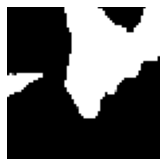

In [9]:
tensorImg = masksDS[6][0]
numpyImg = tensorImg.numpy()[0]
#Pooling = skimage.measure.block_reduce(numpyImg, (2,2), np.max) 
plt.figure()
plt.subplot(1, 2, 1); plt.imshow(numpyImg,  cmap='gray');  plt.axis('off')
#plt.subplot(1, 2, 2); plt.imshow(mPooling,cmap = 'gray' ); plt.axis('off')
plt.show()

torch.Size([64, 1, 64, 64])


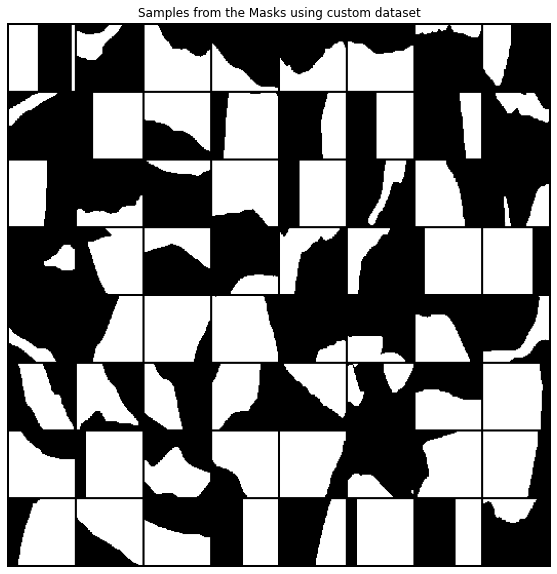

In [10]:
it=iter(dataloaderCustomDS)
real_batch = next(iter(it))
plt.figure(figsize=(10,10))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)),cmap='gray')
plt.axis('off')
plt.title('Samples from the Masks using custom dataset');
plt.show()

# Treinamento

In [11]:
Decoders = nn.ModuleList([Decoder_MLP(latent_dim=100, in_channel=1, im_size=64, hiddens=[256, 512, 1024])])
MabVae = MabVAE(dataloaderCustomDS, Decoders, eps=0.3, i=0)
trainer = Trainer(gpus=1, max_epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
trainer.fit(MabVae)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: d:\_0Luciano\_0PHD\0code\GenerativeModels\VariationalAutoEncoders\vae2\lightning_logs

  | Name     | Type       | Params
----------------------------------------
0 | decoders | ModuleList | 4.9 M 
1 | encoder  | Encoder    | 8.0 M 
----------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.653    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 26/26 [00:05<00:00,  4.77it/s, loss=2.06e+06, v_num=0]


In [13]:
MabVae.NbDraws/torch.sum(MabVae.NbDraws)

tensor([1.], device='cuda:0')

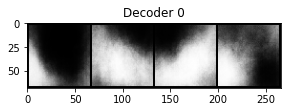

In [102]:
fixed_noise=torch.randn(4,100)
plt.figure(figsize=(10,10))
for i,decoder in enumerate(Decoders):
  fake=decoder(fixed_noise).detach()
  plt.subplot(3,2,i+1)
  plt.title(f'Decoder {i}')
  plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))

plt.savefig(f'Decoders_MASK.png')

In [110]:
blurredAndBinarizedTensorImages = transformOut(fake)

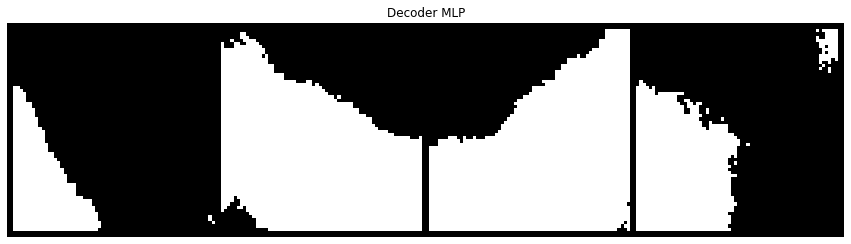

In [111]:
plt.figure(figsize=(15,15))
plt.title(f'Decoder MLP')
plt.axis('off')
plt.imshow(np.transpose(utils.make_grid(blurredAndBinarizedTensorImages,padding=2,normalize=True).cpu(),(1,2,0)))

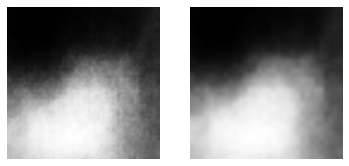

In [16]:
img = fake[0]
npyImg = img.numpy()[0]
mPooling = skm.block_reduce(npyImg, (2,2), np.max) 
fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[0].imshow(npyImg, interpolation='bilinear', cmap= 'gray' );  
ax[1].imshow(mPooling,  interpolation='bilinear', cmap='gray'); 
ax[1].axis('off')
plt.show()

(-0.5, 529.5, 529.5, -0.5)

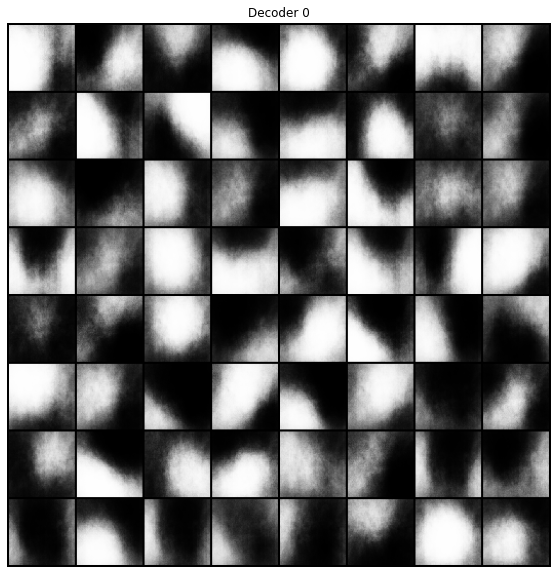

In [112]:
samples = 64
MLP= Decoders[0]
fixed_noise=torch.randn(samples,100)

plt.figure(figsize=(10,10))
fake=MLP(fixed_noise).detach()
plt.title(f'Decoder {i}')
plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))
plt.axis('off')

(-0.5, 529.5, 529.5, -0.5)

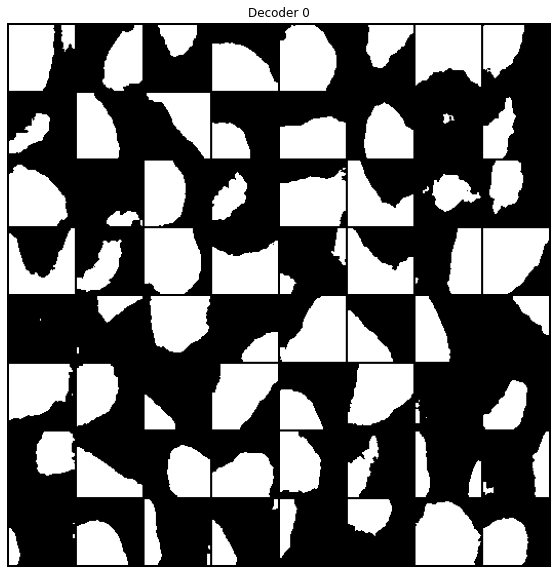

In [114]:
blurredAndBinarizedTensorImages = transformOut(fake)
plt.figure(figsize=(10,10))
plt.title(f'Decoder {i}')
plt.imshow(np.transpose(utils.make_grid(blurredAndBinarizedTensorImages,padding=2,normalize=True).cpu(),(1,2,0)))
plt.axis('off')

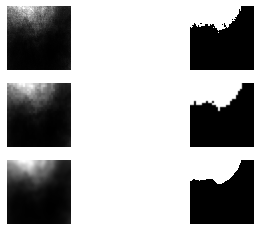

In [35]:
# BEST threshold method to mask => gaussian
thresh = 0.1

predictImg = fake[0].numpy()[0]

npyImg = predictImg
npyImg_bw       = cv2.threshold(npyImg, thresh, 255, cv2.THRESH_BINARY)[1]

pooled = skm.block_reduce(npyImg, (2,2), np.max) 
pooled_bw = cv2.threshold(pooled, thresh, 255, cv2.THRESH_BINARY)[1]

blurred = cv2.GaussianBlur(npyImg, (7, 7), 0)
blurred_bw       = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY)[1]

images=(npyImg,npyImg_bw,pooled,pooled_bw,blurred,blurred_bw)
imagesEnum = enumerate(images)

linhas=3
fig, ax = plt.subplots(linhas, 2 ) #,figsize=(10,10))
for i,img in imagesEnum:
    ax[int(i/2),i%2].axis('off')
    ax[int(i/2),i%2].imshow(img, cmap= 'gray' ); 
plt.show()

In [36]:
fake.numpy

tensor([[[[0.2471, 0.2672, 0.3230,  ..., 0.0712, 0.0626, 0.0659],
          [0.2834, 0.2894, 0.3163,  ..., 0.0749, 0.0807, 0.0743],
          [0.2523, 0.2994, 0.2568,  ..., 0.0623, 0.0584, 0.0595],
          ...,
          [0.0200, 0.0169, 0.0229,  ..., 0.0467, 0.0671, 0.0693],
          [0.0250, 0.0184, 0.0150,  ..., 0.0437, 0.0509, 0.0631],
          [0.0208, 0.0215, 0.0195,  ..., 0.0507, 0.0508, 0.0544]]],


        [[[0.7867, 0.7681, 0.8197,  ..., 0.0311, 0.0322, 0.0375],
          [0.8227, 0.8241, 0.8507,  ..., 0.0321, 0.0377, 0.0337],
          [0.8496, 0.8415, 0.8743,  ..., 0.0322, 0.0418, 0.0314],
          ...,
          [0.9925, 0.9938, 0.9953,  ..., 0.0612, 0.0661, 0.0736],
          [0.9934, 0.9934, 0.9954,  ..., 0.0614, 0.0717, 0.0792],
          [0.9934, 0.9932, 0.9953,  ..., 0.0694, 0.0697, 0.0594]]],


        [[[0.0894, 0.0679, 0.0868,  ..., 0.2808, 0.3006, 0.2506],
          [0.1067, 0.0800, 0.0980,  ..., 0.3107, 0.3013, 0.2635],
          [0.1186, 0.1010, 0.0966,  ..